In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import triangle as tr
import imageio

import torch
from PIL import Image
import sys
import IPython.display
from co_tracker.cotracker.utils.visualizer import read_video_from_path

import sys
sys.path.append('/folder/path/SketchAnim/')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print("Using Device:", device)

Using Device: cuda:0


## Input

In [3]:
root = 'input/path/'

sketch_img_filepath = root+'sketch.png'
video_filepath = root+'video.gif'
video_skeleton_vertices_filepath = root+'video_skeleton_vertices.txt'
sketch_skeleton_vertices_filepath = root+'sketch_skeleton_vertices.txt'
skeleton_edges_filepath = root+'skeleton_edges.txt'
tracked_vertices_filepath = root+'outputs/skeleton_vertices_across_frames.txt'

videoframe_filepath = root+'videoframe.png'

# OUTPUT FILES
output_filepath = root+'outputs/'
tracking_output_filepath = root+'outputs/'
output_animation_directory = root+'outputs/'

num_boundary_samples = 200

In [4]:
sketch_img = np.asarray(Image.open(sketch_img_filepath))
video_img = np.asarray(Image.open(videoframe_filepath).convert('RGBA'))
video = read_video_from_path(video_filepath)

video_skeleton_vertices = np.loadtxt(video_skeleton_vertices_filepath)
video_skeleton_vertices = video_skeleton_vertices * video_img.shape[:2]
skeleton_edges = np.loadtxt(skeleton_edges_filepath, dtype=int)

sketch_skeleton_vertices = None
video_skeleton_vertices_across_frames = None

try:
    sketch_skeleton_vertices = np.loadtxt(sketch_skeleton_vertices_filepath)
    sketch_skeleton_vertices = sketch_skeleton_vertices * sketch_img.shape[:2]
except:
    print('No sketch skeleton provided')

try:
    video_skeleton_vertices_across_frames = np.loadtxt(tracked_vertices_filepath)
    video_skeleton_vertices_across_frames = video_skeleton_vertices_across_frames.reshape(
        (video_skeleton_vertices_across_frames.shape[0],video_skeleton_vertices_across_frames.shape[1]//2,2))
except:
    print('No tracked vertices provided')

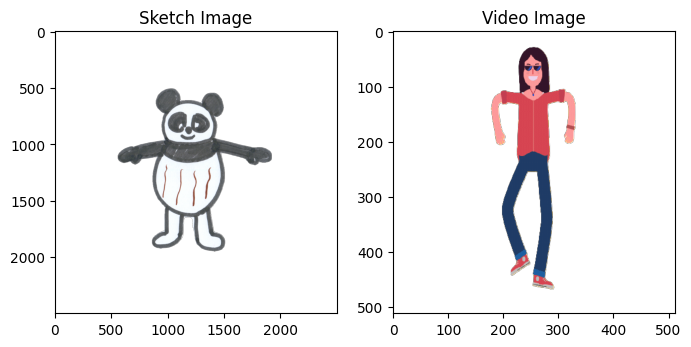

In [5]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(sketch_img)
plt.title('Sketch Image')

plt.subplot(1, 2, 2)
plt.imshow(video_img)
plt.title('Video Image')

plt.show()

In [6]:
# from skeleton_mapping import plot_skeleton_on_image

# sketch_img_pil = Image.open(sketch_img_filepath)

# sketch_img_rgb = Image.new("RGB", sketch_img_pil.size, "white")
# sketch_img_rgb.paste(sketch_img_pil, (0, 0), sketch_img_pil)

# sketch_skeleton_plot = plot_skeleton_on_image(sketch_img_rgb, sketch_skeleton_vertices, skeleton_edges)

# plt.imshow(sketch_skeleton_plot)

In [7]:
# from PIL import Image
# Image.fromarray(sketch_skeleton_plot).save('result_frames/giraffe_sketch_skeleton.png')

## Segmentation

In [8]:
# TODO: Use Segment Anything to segment sketch and video frame. Currently segmenting from transparent image

from CDT import CreateSilhouette
sketch_silhouette = CreateSilhouette(sketch_img)
video_silhouette = CreateSilhouette(video_img)

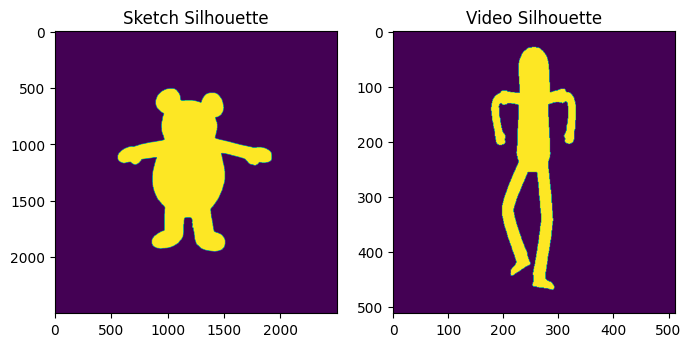

In [9]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(sketch_silhouette)
plt.title('Sketch Silhouette')

plt.subplot(1, 2, 2)
plt.imshow(video_silhouette)
plt.title('Video Silhouette')

plt.show()

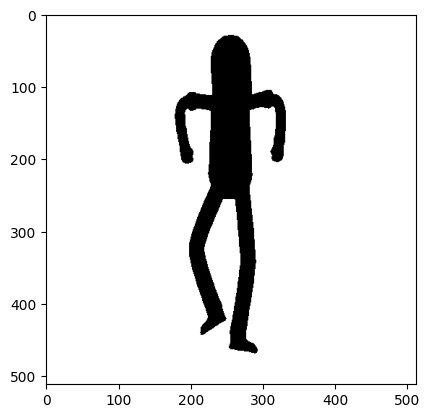

In [10]:
sketch_silhouette_rgb = cv2.cvtColor(255-sketch_silhouette, cv2.COLOR_GRAY2RGB)
video_silhouette_rgb = cv2.cvtColor(255-video_silhouette, cv2.COLOR_GRAY2RGB)
plt.imshow(video_silhouette_rgb)

In [11]:
# Save Silhouette

from PIL import Image
Image.fromarray(sketch_silhouette_rgb).save('result_frames/demo_sketch_silhouette.png')
Image.fromarray(video_silhouette_rgb).save('result_frames/demo_driver_silhouette.png')

2085
680


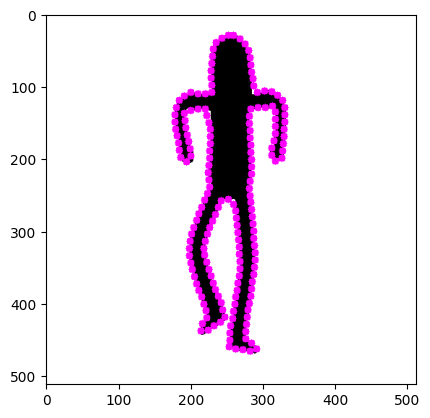

In [12]:
# Plot and Save Boundary
from CDT import GetBoundaryFromSilhouette, PlotBoundaryOnImage
sketch_boundary = GetBoundaryFromSilhouette(sketch_silhouette, 1, 0, 50)
video_boundary = GetBoundaryFromSilhouette(video_silhouette, 1, 0, 10)
sketch_boundary_plot = PlotBoundaryOnImage(sketch_silhouette_rgb, sketch_boundary)
video_boundary_plot = PlotBoundaryOnImage(video_silhouette_rgb, video_boundary)
plt.imshow(video_boundary_plot)

In [13]:
sketch_boundary.shape

(240, 2)

In [14]:
# Image.fromarray(sketch_boundary_plot).save('result_frames/demo_sketch_boundary.png')
# Image.fromarray(video_boundary_plot).save('result_frames/demo_driver_boundary.png')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


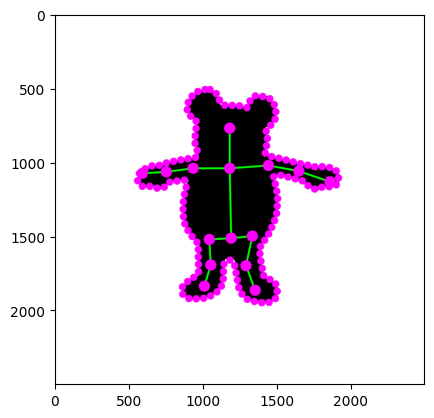

In [15]:
# Plot Skeleton with Silhouette Boundary

from skeleton_mapping import plot_skeleton_on_image
video_skeleton_plot = plot_skeleton_on_image(video_boundary_plot, video_skeleton_vertices, skeleton_edges)
sketch_skeleton_plot = plot_skeleton_on_image(sketch_boundary_plot, sketch_skeleton_vertices, skeleton_edges)
plt.imshow(sketch_skeleton_plot)

In [16]:
# Image.fromarray(sketch_skeleton_plot).save('result_frames/demo_sketch_skeleton.png')
# Image.fromarray(video_skeleton_plot).save('result_frames/demo_driver_skeleton.png')

## Skeleton Mapping

In [17]:
from skeleton_mapping import SkeletonMap, plot_skeleton_on_silhouette

if sketch_skeleton_vertices is None:
    sketch_skeleton_vertices, video_skeleton_plot, sketch_skeleton_plot = SkeletonMap(
        video_silhouette,
        sketch_silhouette,
        video_skeleton_vertices,
        device=device,
        skeleton_edges=skeleton_edges,
        return_plot=True,
        verbose=True
    )
else:
    video_skeleton_plot = plot_skeleton_on_silhouette(video_silhouette, video_skeleton_vertices, skeleton_edges)
    sketch_skeleton_plot = plot_skeleton_on_silhouette(sketch_silhouette, sketch_skeleton_vertices, skeleton_edges)

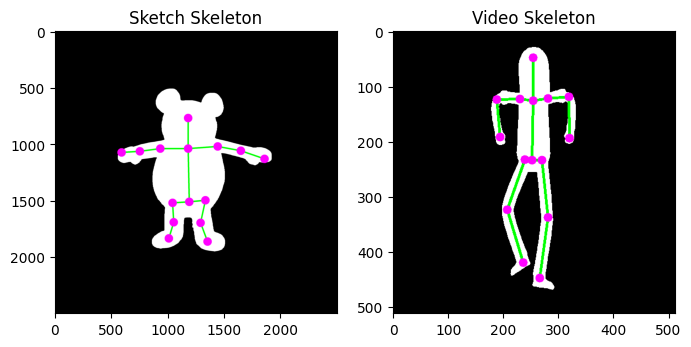

In [18]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
plt.imshow(sketch_skeleton_plot)
plt.title('Sketch Skeleton')

plt.subplot(1, 2, 2)
plt.imshow(video_skeleton_plot)
plt.title('Video Skeleton')

plt.savefig(output_filepath+'skeleton_mapping.png')
plt.show()

## Point Tracking

In [19]:
from point_tracking import PointTracking

video_skeleton_vertices = np.array(video_skeleton_vertices, dtype=np.float32)

if video_skeleton_vertices_across_frames is None:
    video_skeleton_vertices_across_frames = PointTracking(
        video_frames=video,
        input_points=video_skeleton_vertices,
        edges=skeleton_edges,
        device=device,
        output_visualise_filepath=tracking_output_filepath,
        output_vertices_filepath=tracking_output_filepath
    )
else:
    print('Using precomputed tracking data')

Using precomputed tracking data


In [20]:
IPython.display.display(IPython.display.Image(url=tracking_output_filepath+'tracking.gif', width=360))

In [21]:
# from skeleton_mapping import plot_skeleton_on_image
# frame_no = 5
# plot_on_frame = plot_skeleton_on_image(video[5], video_skeleton_vertices_across_frames[5], skeleton_edges, output_shape=(3000,3000))
# plt.imshow(plot_on_frame)
# image = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

In [22]:
# Image.fromarray(plot_on_frame).save(f'result_frames/giraffe_track_frame{frame_no}.png')

## Motion Transfer

In [23]:
from motion_transfer import SkeletonMotionTransfer, GetMeshTransformsFromSkeleton, GetVirtualVertexDepth

sketch_skeleton_vertices_across_frames = SkeletonMotionTransfer(
    fixed_vertices_across_frames=video_skeleton_vertices_across_frames,
    moving_vertices_rest_pose=sketch_skeleton_vertices,
    edges=skeleton_edges,
    sketch_img=sketch_img,
    video_img=video_img
)

[1250. 1250.]
[1231.5 1238.5]


In [40]:
video_skeleton_frames = []
for skeleton_vertices in video_skeleton_vertices_across_frames:
    plot = np.ones(video_img[:,:,:3].shape, dtype=np.uint8)*255
    plot = plot_skeleton_on_image(plot, skeleton_vertices, skeleton_edges, output_shape=(2000,2000))
    video_skeleton_frames.append(plot)

In [41]:
def create_video(image_list, output_file='result_frames/video_skeleton.mp4', fps=10):
    # Determine the shape of the images
    height, width, _ = image_list[0].shape

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can try other codecs like 'XVID' or 'MJPG'
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    # Write each frame to the video
    for image in image_list:
        out.write(image)

    # Release the VideoWriter object
    out.release()
create_video(video_skeleton_frames)

In [ ]:
def render_triangulation(image, triangulation_vertices, triangulation_faces, vertex_colour = (0, 169, 0), edge_colour = (0, 169, 0)):
    img_copy = image.copy()
    
    # For each triangle, draw corresponding edges on the image
    img_triangulation = img_copy.copy()
    # for simplice in triangulation.simplices:
    for simplice in triangulation_faces:
        point0 = (int(triangulation_vertices[simplice[0]][0]), int(triangulation_vertices[simplice[0]][1]))
        point1 = (int(triangulation_vertices[simplice[1]][0]), int(triangulation_vertices[simplice[1]][1]))
        point2 = (int(triangulation_vertices[simplice[2]][0]), int(triangulation_vertices[simplice[2]][1]))
        img_triangulation = cv2.line(img_triangulation, point0, point1, edge_colour, 1)
        img_triangulation = cv2.line(img_triangulation, point1, point2, edge_colour, 1)
        img_triangulation = cv2.line(img_triangulation, point0, point2, edge_colour, 1)

    # Displaying the points on the original figure
    for point in triangulation_vertices:
        cv2.circle(img_copy, (int(point[0]), int(point[1])), 2, vertex_colour, -1)
    
    return img_triangulation

In [ ]:
from CDT import GetCDT, GetBoundaryFromSilhouette

sketch_boundary = GetBoundaryFromSilhouette(sketch_silhouette, 700, 1, -1)

sketch_triangulation = GetCDT(
    boundary_points=sketch_boundary,
    skeleton_vertices=sketch_skeleton_vertices,
    skeleton_edges=skeleton_edges,
    flags = 'pa500'
)

2084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


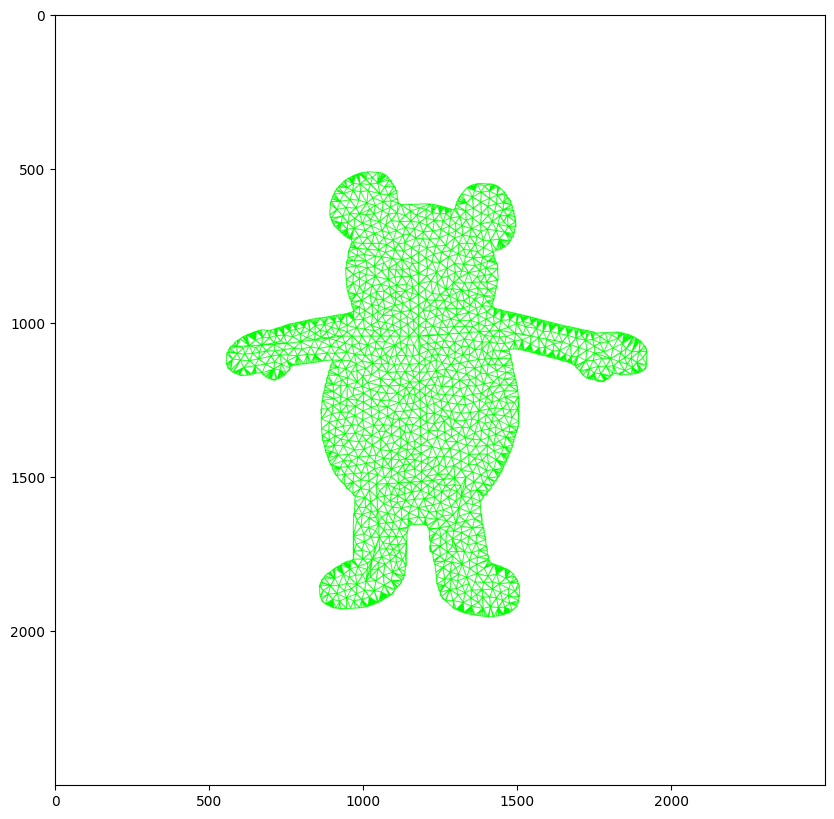

In [ ]:
from CDT import PlotTriangulationOnImage

# sketch_silhouette_rgb = cv2.cvtColor(sketch_silhouette, cv2.COLOR_GRAY2RGB)
sketch_triangulation_background = np.ones(sketch_img[:,:,:3].shape)

triangulation = PlotTriangulationOnImage(sketch_triangulation_background, sketch_triangulation['vertices'],  sketch_triangulation['triangles'])

plt.figure(figsize=(10,10))
plt.imshow(triangulation)

In [ ]:
# Image.fromarray(triangulation).save('result_frames/giraffe_triangulation.png')

In [ ]:
bone_depths = GetVirtualVertexDepth(
    edges = skeleton_edges
)

mesh_vertices_across_frames = GetMeshTransformsFromSkeleton(
    mesh=sketch_triangulation,
    vertices_across_frames=sketch_skeleton_vertices_across_frames,
    vertices_rest_pose = sketch_skeleton_vertices,
    edges = skeleton_edges,
    bone_depths = bone_depths,
)

## Animation

In [ ]:
from renderer import RenderFrameAnimation

RenderFrameAnimation(
    moving_img_filepath=sketch_img_filepath,
    triangulation=sketch_triangulation,
    mesh_vertices_across_frames=mesh_vertices_across_frames,
    output_directory=output_animation_directory,
    video_frames=[frame for frame in imageio.get_reader(video_filepath)],
    device=device,
    verbose=True)

Animation saved in samples/b13_1/outputs/renderer_animation.gif
Sidebyside saved in samples/b13_1/outputs/renderer_sidebyside.gif


In [ ]:
import time

timestamp = int(time.time())
animation_url = f"{tracking_output_filepath}renderer_animation.gif?{timestamp}"

IPython.display.display(IPython.display.Image(url=animation_url, width=360))